<a href="https://colab.research.google.com/github/ehager77/intro_to_ai/blob/master/intro_to_ai_hw3_ehager_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [782]:
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
import numpy as np
import pandas as pd
import os
import seaborn as sns
from google.colab import drive
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [783]:
print(tf.__version__)

2.3.0


In [784]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [785]:
# defining global variable path
# Location of my dataset on My Google Drive
root = '/content/drive/My Drive/95891-F20-hw3-data'
data = '/content/drive/My Drive/95891-F20-hw3-data/images'

In [786]:
IMG_SIZE = (224, 224)
BATCH_SIZE=32

In [787]:
train_dataset = image_dataset_from_directory(data+'/train',
                                             validation_split=.1,
                                             subset='training',
                                             seed = 123,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 1000 files belonging to 10 classes.
Using 900 files for training.


In [788]:
validation_dataset = image_dataset_from_directory(data+'/train',
                                             validation_split=.1,
                                             subset='validation',
                                             seed = 123,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 1000 files belonging to 10 classes.
Using 100 files for validation.


In [789]:
test_dataset = image_dataset_from_directory(data+'/test',
                                             shuffle=False,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 1848 files belonging to 10 classes.


In [790]:
class_names = train_dataset.class_names
NUM_CLASSES = len(class_names)
print('Number of classes:', NUM_CLASSES)
print(class_names)

Number of classes: 10
['airport_inside', 'bathroom', 'buffet', 'classroom', 'dining_room', 'garage', 'jewelleryshop', 'meeting_room', 'restaurant', 'subway']


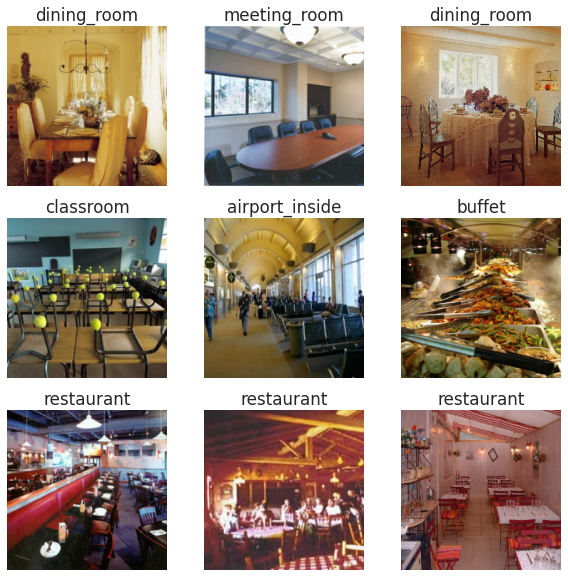

In [791]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [792]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [793]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [794]:
# Create data augmentation layer
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(224, 
                                                              224,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

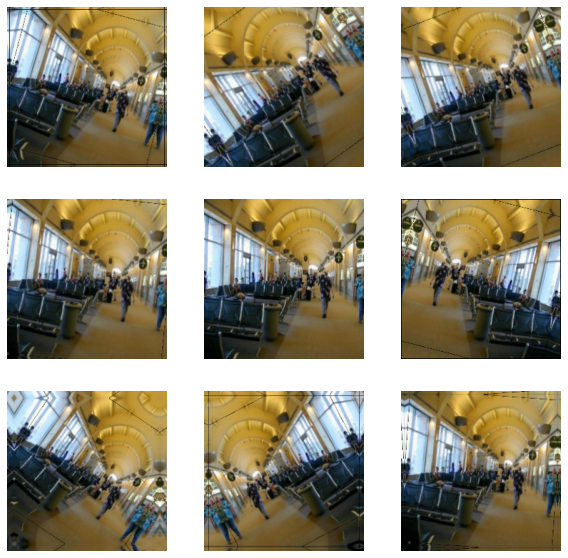

In [795]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [796]:
# Create the base model from the pre-trained model MOBILENETV2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
# Freeze bottom layers
base_model.trainable = False

In [797]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [798]:
# CREATE RESCALING LAYER
preprocess_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [799]:
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.30)(x)# Regularize with dropout
x = keras.layers.Flatten()(x)
# Hidden Layers
for num in np.geomspace(512, 16, endpoint=False, num=5):
  print(num)
  x = keras.layers.Dense(num, activation='relu')(x)
# Prediction Layer
outputs = keras.layers.Dense(NUM_CLASSES)(x)
model = keras.Model(inputs, outputs)

model.summary()

512.0000000000001
256.0
127.99999999999999
64.00000000000001
32.00000000000001
Model: "functional_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_53 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_20 (Sequential)   (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling_17 (Rescaling)     (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_31  (None, 1280)              0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 1280)              0         
________________________________________

In [800]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [801]:
len(model.trainable_variables)

12

In [802]:
initial_epochs = 30

loss0, accuracy0 = model.evaluate(validation_dataset)

4/4 [==============================] - 0s 31ms/step - loss: 2.3886 - accuracy: 0.1000


In [803]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.39
initial accuracy: 0.10


In [804]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/30
29/29 [==============================] - 1s 50ms/step - loss: 2.2780 - accuracy: 0.1444 - val_loss: 2.1982 - val_accuracy: 0.2500
Epoch 2/30
29/29 [==============================] - 1s 50ms/step - loss: 2.1237 - accuracy: 0.2878 - val_loss: 1.9792 - val_accuracy: 0.3600
Epoch 3/30
29/29 [==============================] - 1s 49ms/step - loss: 1.8585 - accuracy: 0.4156 - val_loss: 1.6315 - val_accuracy: 0.5500
Epoch 4/30
29/29 [==============================] - 1s 49ms/step - loss: 1.5557 - accuracy: 0.5189 - val_loss: 1.2765 - val_accuracy: 0.7000
Epoch 5/30
29/29 [==============================] - 1s 50ms/step - loss: 1.2694 - accuracy: 0.6244 - val_loss: 1.0110 - val_accuracy: 0.7400
Epoch 6/30
29/29 [==============================] - 1s 50ms/step - loss: 1.0308 - accuracy: 0.6756 - val_loss: 0.8973 - val_accuracy: 0.7100
Epoch 7/30
29/29 [==============================] - 1s 49ms/step - loss: 0.9279 - accuracy: 0.7044 - val_loss: 0.7697 - val_accuracy: 0.7500
Epoch 8/30
29

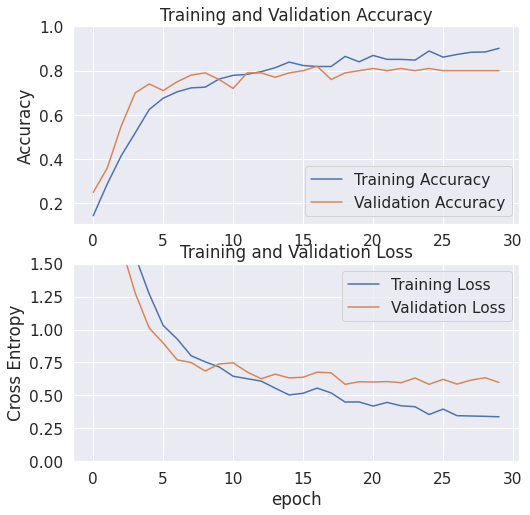

In [805]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [806]:
# Unfreeze bottom layers
base_model.trainable = True

In [807]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 130

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [808]:
model.compile(optimizer=tf.keras.optimizers.Adam(base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [809]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 30/60
29/29 [==============================] - 2s 80ms/step - loss: 0.3058 - accuracy: 0.8889 - val_loss: 0.5881 - val_accuracy: 0.8000
Epoch 31/60
29/29 [==============================] - 2s 57ms/step - loss: 0.2803 - accuracy: 0.9111 - val_loss: 0.5587 - val_accuracy: 0.8000
Epoch 32/60
29/29 [==============================] - 2s 56ms/step - loss: 0.2792 - accuracy: 0.9111 - val_loss: 0.5841 - val_accuracy: 0.8000
Epoch 33/60
29/29 [==============================] - 2s 57ms/step - loss: 0.2838 - accuracy: 0.8989 - val_loss: 0.5806 - val_accuracy: 0.8100
Epoch 34/60
29/29 [==============================] - 2s 57ms/step - loss: 0.2509 - accuracy: 0.9156 - val_loss: 0.6369 - val_accuracy: 0.8200
Epoch 35/60
29/29 [==============================] - 2s 57ms/step - loss: 0.2772 - accuracy: 0.9122 - val_loss: 0.5943 - val_accuracy: 0.7900
Epoch 36/60
29/29 [==============================] - 2s 57ms/step - loss: 0.2476 - accuracy: 0.9156 - val_loss: 0.5714 - val_accuracy: 0.8100
Epoch 

In [810]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

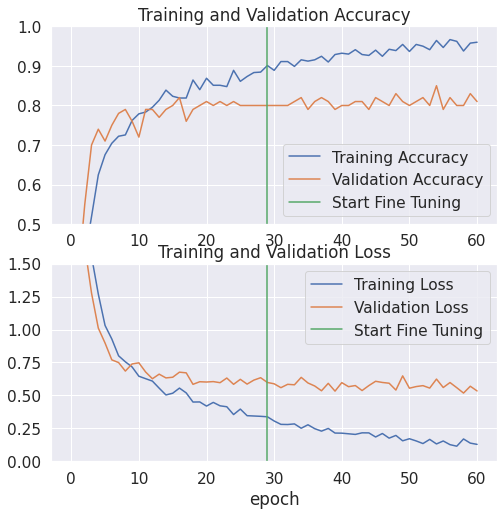

In [811]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.5])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [812]:
# 1. Accuracy of model on test data
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

58/58 [==============================] - 11s 193ms/step - loss: 0.9272 - accuracy: 0.7251
Test accuracy : 0.7251082062721252


In [813]:
test_image_batch, test_label_batch = next(iter(test_dataset))
true_label_ids = np.argmax(test_label_batch, axis=-1)
print("Test batch shape:", test_image_batch.shape)

Test batch shape: (32, 224, 224, 3)


In [814]:
# Checking if models working by predicting on first few elements
tf_model_predictions = model.predict(test_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = class_names
print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,airport_inside,bathroom,buffet,classroom,dining_room,garage,jewelleryshop,meeting_room,restaurant,subway
0,4.053759,-3.231589,-3.341220,-1.434640,-1.623195,2.587971,2.476931,-1.828449,-0.896639,2.939048
1,11.189967,-5.095651,8.804170,-7.281596,-5.448999,-0.692860,0.928371,-2.172817,-3.742173,1.773812
2,10.072491,-2.700988,-1.970801,-8.060892,-3.210805,-4.515877,0.728181,1.620355,-0.890851,10.086150
3,8.653494,-1.518640,-4.027125,-7.765370,-6.825243,-4.140200,0.345434,-0.154392,-2.474854,11.250515
4,7.914770,-7.466683,-1.978670,-6.155092,-2.242523,-2.221458,-0.021283,2.526725,2.167319,9.381043


In [815]:
# Checking to see what preductions and test_label_batch returns
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
print(predicted_ids)
test_label_arr = test_label_batch.numpy()
print(test_label_arr)

[0 0 9 9 9 7 0 0 0 4 0 0 0 0 9 9 0 0 9 0 7 0 0 0 0 0 9 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


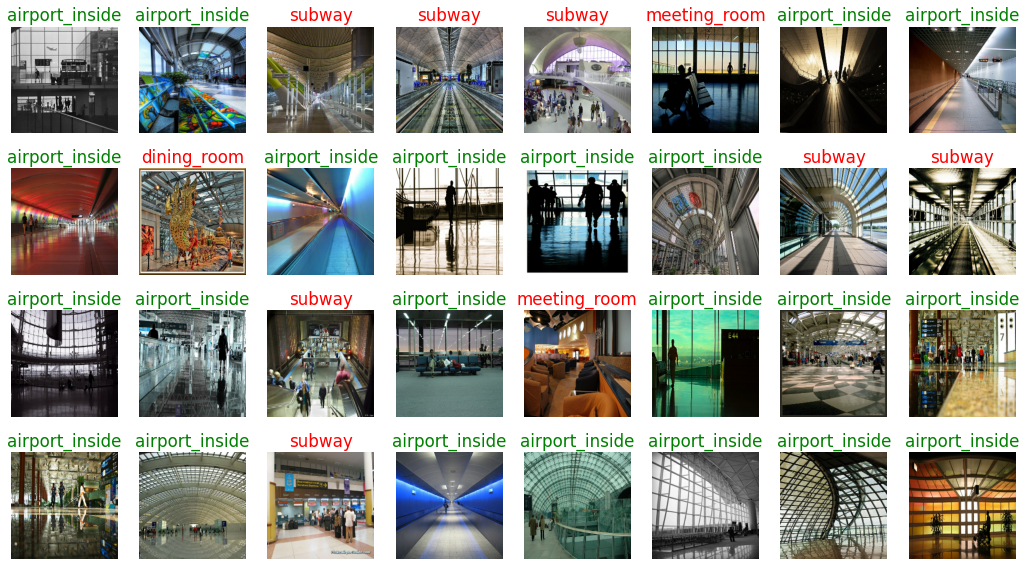

In [816]:
# Visualizing correct and incorrect predicitions
plt.figure(figsize=(18, 10))
for i in range(BATCH_SIZE):
  ax = plt.subplot(4, 8, i + 1)
  plt.imshow(test_image_batch[i].numpy().astype("uint8"))
  if test_label_arr[i] == predicted_ids[i]:
    color = 'green'
  else:
    color = 'red'
  plt.title(class_names[predicted_ids[i]], color = color)
  plt.axis("off")

In [817]:
# Getting all predicitions
predictions = model.predict(test_dataset)
pred_dataframe = pd.DataFrame(predictions)
pred_dataframe.columns = class_names
print("Prediction results for the all elements")
pred_dataframe

Prediction results for the all elements


,airport_inside,bathroom,buffet,classroom,dining_room,garage,jewelleryshop,meeting_room,restaurant,subway
0,4.053759,-3.231589,-3.341220,-1.434640,-1.623195,2.587971,2.476931,-1.828449,-0.896639,2.939048
1,11.189967,-5.095651,8.804170,-7.281596,-5.448999,-0.692860,0.928371,-2.172817,-3.742173,1.773812
2,10.072491,-2.700988,-1.970801,-8.060892,-3.210805,-4.515877,0.728181,1.620355,-0.890851,10.086150
3,8.653494,-1.518640,-4.027125,-7.765370,-6.825243,-4.140200,0.345434,-0.154392,-2.474854,11.250515
4,7.914770,-7.466683,-1.978670,-6.155092,-2.242523,-2.221458,-0.021283,2.526725,2.167319,9.381043
...,...,...,...,...,...,...,...,...,...,...
1843,5.943837,-0.992092,-5.876628,-8.648564,-2.566915,-5.171000,3.719492,-2.868281,-0.293201,14.336456
1844,5.738327,-1.300511,-5.740057,-4.295438,-7.010856,-4.808515,0.997935,0.743252,-1.596438,12.475410
1845,6.926961,-0.415316,-4.939498,-6.446101,-6.610616,-3.983270,-1.356377,1.206430,-3.321728,12.857278
1846,6.081374,-0.463506,-6.429996,-2.779700,-8.224399,-5.509659,1.976768,1.185722,-4.601879,11.146035


In [818]:
# Formatting data to plot in confusion matrix
predicted_ids = np.argmax(predictions, axis=-1)
predicted_ids = list(predicted_ids)
# print('Predicted labels:', predicted_ids)
# print('Number of labels in list:', len(predicted_ids))

In [819]:
test_ds = test_dataset.take(len(test_dataset))
test_labels = []
for image, label in test_ds:  # example is (image, label)
  for l in label.numpy():
    test_labels.append(l)
# print('Test labels:', test_labels)
# print('Number of labels in list:', len(test_labels))

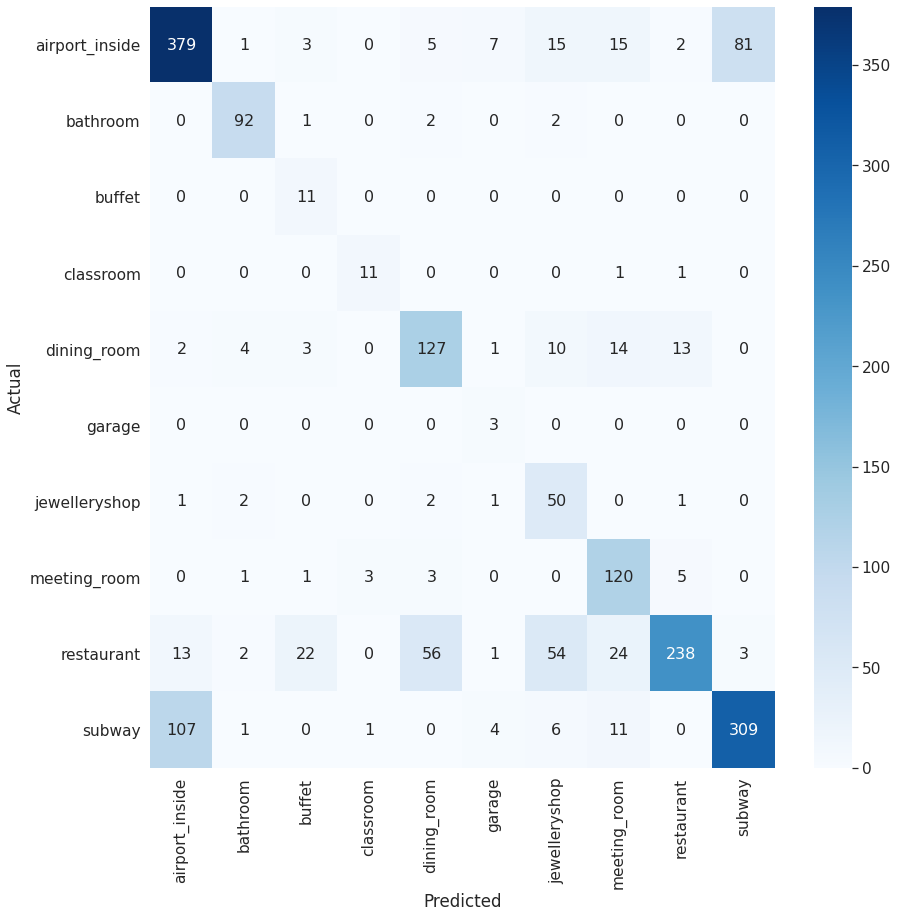

In [820]:
# 2. Confusion Matrix with raw data values
y_true = test_labels
y_pred = predicted_ids
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=class_names, index = class_names)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (14,14))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g')# font size


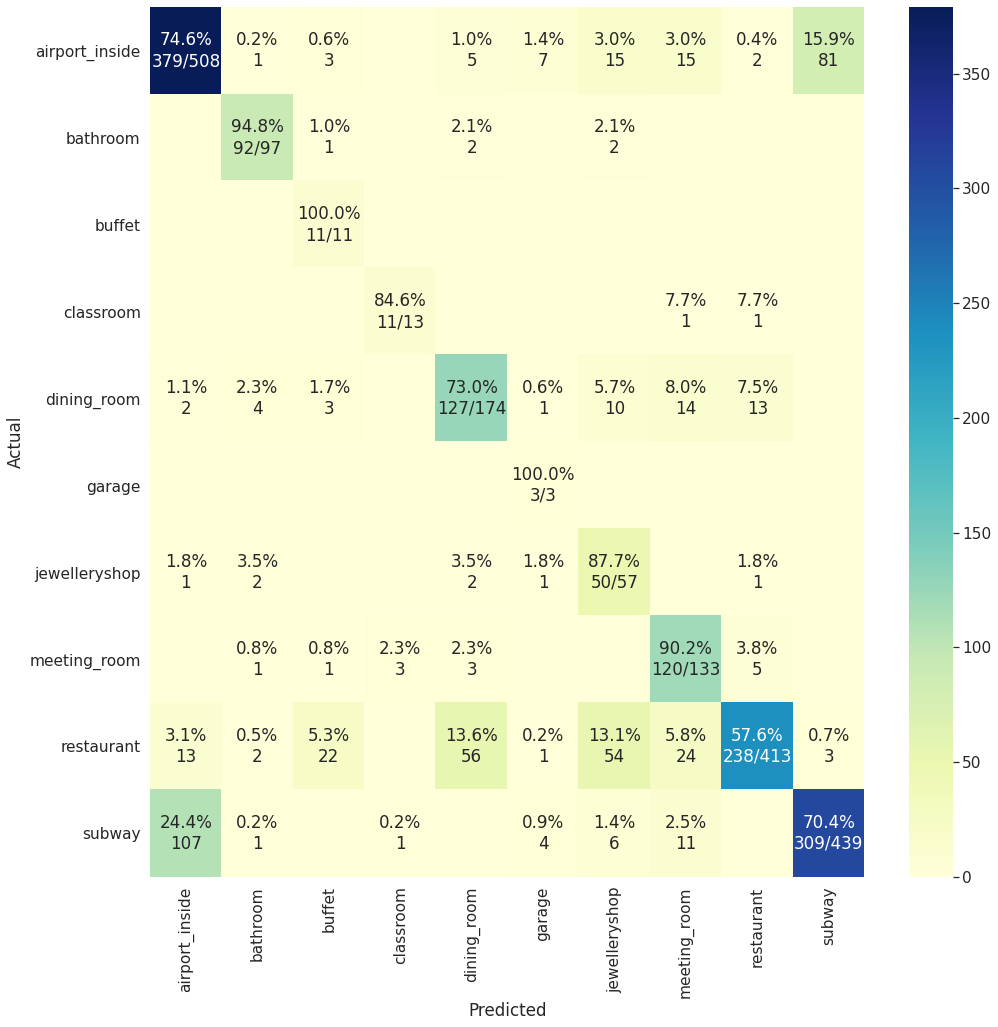

In [821]:
# 3. Normalized Confusion Matrix with showing accuracy per category
# 4. Most accurately predicted categories are both buffet and garage with 100% accuracy
# 5. Least accurately predicted category is restaurant at roughly 58% accuracy and it's most often confused with dining room about 14% of the time.
def plot_cm(y_true, y_pred, figsize=(16,16)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    
plot_cm(y_true, y_pred)

In [824]:
# Calculating precision and recall scores per category and storing them in pandas dataframe to for visualization
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_true, y_pred, average=None)
recall_sc = recall_score(y_true, y_pred, average=None)
df = pd.DataFrame(data=precision, index=class_names, columns=['Precision Score'])
df['Recall Score'] = recall_sc
print(df)

                Precision Score  Recall Score
airport_inside         0.754980      0.746063
bathroom               0.893204      0.948454
buffet                 0.268293      1.000000
classroom              0.733333      0.846154
dining_room            0.651282      0.729885
garage                 0.176471      1.000000
jewelleryshop          0.364964      0.877193
meeting_room           0.648649      0.902256
restaurant             0.915385      0.576271
subway                 0.786260      0.703872


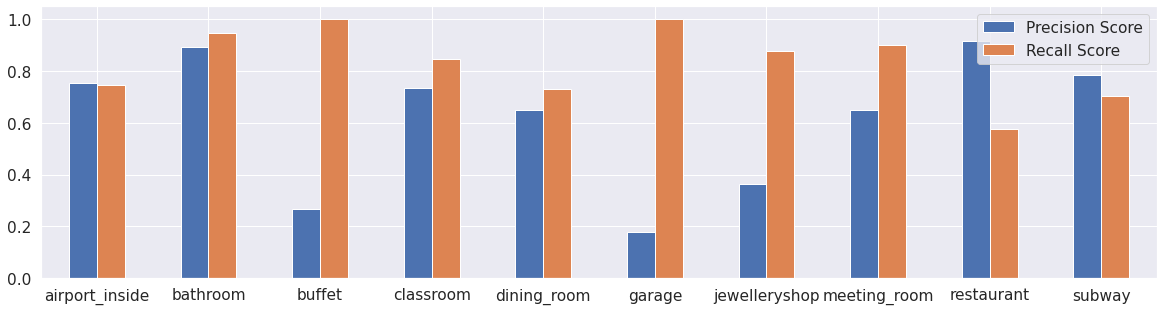

In [823]:
# 6. Plotting grouped bar chart with precision and recall scores per category
ax = df.plot.bar(rot=0, figsize=(20,5))